In [1]:
import findspark
findspark.init()
from pyspark import SparkContext
sc = SparkContext(master="local[4]")

In [3]:
import numpy as np

TOTAL = 1000000
dots = sc.parallelize([2.0 * np.random.random(2) - 1.0
                       for i in range(TOTAL)]) \
         .cache()
print("Number of random points:", dots.count())

stats = dots.stats()
print('Mean:', stats.mean())
print('stdev:', stats.stdev())
print(dots.take(5))

Number of random points: 1000000
Mean: [-0.00019744 -0.00035965]
stdev: [0.5768445  0.57724805]
[array([-0.77960384,  0.01987534]), array([0.1466355 , 0.92547543]), array([-0.81872805,  0.57957035]), array([0.49892056, 0.05987268]), array([-0.48966823,  0.50691833])]


In [4]:
from operator import itemgetter

# x.itemgetter(a) - fetches value at location a, assuming x is just an iterable (e.g. list)
# sample.map(itemgetter(a)) - returns a new RDD object by applying itemgetter(a) to every element in sample
# sample.map(itemgetter(a)).collect() - Takes the RDD object and returns it as a python list
type(dots.map(itemgetter(0)))

pyspark.rdd.PipelinedRDD

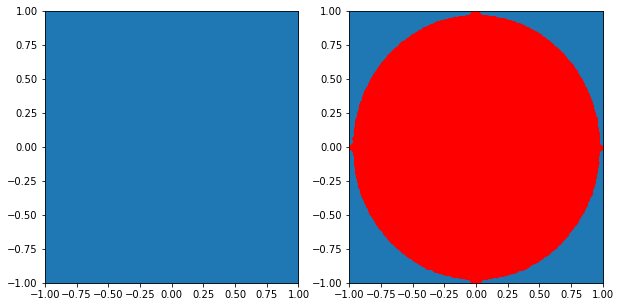

In [5]:
%matplotlib inline
from operator import itemgetter
from matplotlib import pyplot as plt

plt.figure(figsize = (10, 5))

# Plot 1
plt.subplot(1, 2, 1)
plt.xlim((-1.0, 1.0))
plt.ylim((-1.0, 1.0))

sample = dots.sample(False, 0.1)
X = sample.map(itemgetter(0)).collect()
Y = sample.map(itemgetter(1)).collect()
plt.scatter(X, Y)

# Plot 2
plt.subplot(1, 2, 2)
plt.xlim((-1.0, 1.0))
plt.ylim((-1.0, 1.0))

inCircle = lambda v: np.linalg.norm(v) <= 1.0
dotsIn = sample.filter(inCircle).cache()
dotsOut = sample.filter(lambda v: not inCircle(v)).cache()

# inside circle
Xin = dotsIn.map(itemgetter(0)).collect()
Yin = dotsIn.map(itemgetter(1)).collect()
plt.scatter(Xin, Yin, color = 'r')

# outside circle
Xout = dotsOut.map(itemgetter(0)).collect()
Yout = dotsOut.map(itemgetter(1)).collect()
plt.scatter(Xout, Yout)

In [6]:
pi = 4.0 * (dots.filter(inCircle).count()*1.0 / TOTAL)
print("The estimation of \pi is:", pi)

The estimation of \pi is: 3.145068


In [12]:
# Simple operations on plain RDDs
print(sc.parallelize(range(4)).collect()) # Get original RDD back as a list
print(sc.parallelize(range(4)).count())   # Count the number of elements in an RDD
A = sc.parallelize(range(50000000))              # Define a function that generates an RDD
A.reduce(lambda x, y: x+y)                # Use a reduce operation to sum of values of that RDD one at a time.  

[0, 1, 2, 3]
4


1249999975000000

In [13]:
# Examples of (key, value) RDDs
database = sc.parallelize([
    (55632, {'name': 'yoav',  'city': 'jerusalem'} )
    ,(3342, {'name': 'homer', 'town': 'springfield'})])
print(database)
print(database.collect())

print("")
A = sc.parallelize(range(4)).map(lambda x: (x, x*x))
print(A)
print(A.collect())

print("")
A = sc.parallelize([(1,3),(4,100),(1,-5),(3,2)])
print(A)
A = A.reduceByKey(lambda x,y: x*y)
print (A)
print(A.collect())

# Should really be doing large iterations this with an iterator, not a regular list
# for x in xrange(1000000):



ParallelCollectionRDD[53] at parallelize at PythonRDD.scala:184
[(55632, {'name': 'yoav', 'city': 'jerusalem'}), (3342, {'name': 'homer', 'town': 'springfield'})]

PythonRDD[55] at RDD at PythonRDD.scala:49
[(0, 0), (1, 1), (2, 4), (3, 9)]

ParallelCollectionRDD[56] at parallelize at PythonRDD.scala:184
PythonRDD[61] at RDD at PythonRDD.scala:49
[(4, 100), (1, -15), (3, 2)]


In [75]:
# Quiz 1.2 - Given a list l of integers, which of the following 
# expressions compute the average of the elements in the list?
from functools import reduce
l = [1,2,3,4,5,10]

# Create an iterator that's a bunch of 1's the length of the list:
#    ones: map(lambda x: 1, l)
# Sum over that iterator: 
#    denominator =reduce(lambda x, y: x+y, ones)
# Sum over the value of the items in the list: 
#     numerator = reduce(lambda x, y: x+y, l)
# Divide them to get the mean:
#     print(numerator / denominator)

reduce(lambda x, y: x+y, l) / reduce(lambda x, y: x+y, map(lambda x: 1, l))

4.166666666666667

### Week 1, part 2 of 2

# Shortest word in a list

words = {'this', 'is', 'the', 'best', 'mac', 'ever'}
wordRdd = sc.parallelize(words)
wordRdd.reduce(lambda w, v: w if len(w)<len(v) else v)


#### Custom functions in a reduce statement

In [21]:
# Last lexigraphical word among the longest words
words = {'this', 'is', 'the', 'best', 'mac', 'ever'}
def largerThan(x, y):
    if len(x) > len(y): return x
    elif len(y) > len(x): return y
    else: 
        if x > y:
            return x
        else:
            return y
wordRdd = sc.parallelize(words)
wordRdd.reduce(largerThan)

'this'

#### Spark Worker Optimization

In [4]:
from time import time
from pyspark import SparkContext
for j in range(1, 10):
    sc = SparkContext(master="local[%d]"%(j))
    t0 = time()
    for i in range(10):
        sc.parallelize([1,2]*100000).reduce(lambda x,y:x+y)
    print("{} executors, time = {}".format(j, time()-t0))
    sc.stop()

1 executors, time = 1.979173183441162
2 executors, time = 1.6027801036834717
3 executors, time = 1.6311359405517578
4 executors, time = 1.6508269309997559
5 executors, time = 1.6793198585510254
6 executors, time = 1.8819191455841064
7 executors, time = 1.8730149269104004
8 executors, time = 1.7702810764312744
9 executors, time = 1.8310468196868896


#### See the effect of Lazy Evaluation

In [27]:
# New Spark context outside of other cells
sc.stop()
sc = SparkContext(master="local[4]")
RDD=sc.parallelize(range(1000000))

In [29]:
%%time
# Create a dummy function to compute cox(x) from 1 to 100
# Goal is just to take up time
# Note that it takes 420 ms = 13 microseconds
from math import cos
def taketime(i):
    [cos(j) for j in range(100)]
    return cos(i)

CPU times: user 10 µs, sys: 0 ns, total: 10 µs
Wall time: 13.1 µs


In [25]:
taketime(1)

0.5403023058681398

In [38]:
%%time
# Doing the taketime() on all values in the RDD -- 1 Million values
# Expect it to take 1 Million x 13 microsec = 13 seconds
# But it just takes ~20 microseconds!
Interm=RDD.map(lambda x: taketime(x))

CPU times: user 15 µs, sys: 0 ns, total: 15 µs
Wall time: 17.9 µs


In [39]:
print(Interm.toDebugString().decode())

(4) PythonRDD[1] at RDD at PythonRDD.scala:49 []
 |  ParallelCollectionRDD[0] at parallelize at PythonRDD.scala:184 []


In [41]:
%%time
# Takes 8 seconds, << the 13 seconds we expected
print('out=',Interm.reduce(lambda x, y: x+y))

out= -0.2887054679684655
CPU times: user 8.66 ms, sys: 3.66 ms, total: 12.3 ms
Wall time: 9.58 s
